# CSE - 464: Machine Learning Endsemester Assignment
### Satyam Saxena - Chemical Engineering - 17045120
***
In this assignment, I have used a Three Layer Multilayer Perceptron for identifying signs of Diabetic Retinopathy in Messidor Image Sets. All features represent either a detected lesion, a descriptive feature of a anatomical part or an image-level descriptor. 
***

## Importing Libraries

In [30]:
import numpy as np
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt

## Reading the CSV File Containing Data

In [31]:
with open('/Users/satyamsaxena/Downloads/csv_result-messidor_features.csv', 'r') as f:
    dataset = list(csv.reader(f, delimiter=','))

This prints the headers of the data that we have. Note that first column 'id' is the serial number column and the last column 'Class' represents the true label of the images as 1: Having Diabetic Retinopathy or 0: Not having Diabetic Retinopathy 

In [32]:
print(dataset[0])

['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', 'Class']


Here we remove the first row (headers) and first column (id) to obtain the numerical data values

In [33]:
dataset = np.array(dataset[1:],dtype = np.float)
dataset = np.delete(dataset,0,axis=1)
dataset

array([[ 1.      ,  1.      , 22.      , ...,  0.100025,  1.      ,
         0.      ],
       [ 1.      ,  1.      , 24.      , ...,  0.144414,  0.      ,
         0.      ],
       [ 1.      ,  1.      , 62.      , ...,  0.128548,  0.      ,
         1.      ],
       ...,
       [ 1.      ,  0.      , 49.      , ...,  0.129843,  0.      ,
         0.      ],
       [ 1.      ,  1.      , 39.      , ...,  0.10669 ,  1.      ,
         1.      ],
       [ 1.      ,  1.      ,  7.      , ...,  0.088957,  0.      ,
         0.      ]])

We obtain a dataset with 1151 unique records each having 20 features, one of which is the true label

In [34]:
dataset.shape

(1151, 20)

## Splitting into training and test datasets (70% ; 30%)

In [35]:
training_data_size = round(dataset.shape[0]*0.7)
print(training_data_size)
test_data_size = dataset.shape[0] - training_data_size
print(test_data_size)

806
345


In [36]:
dataset_copy = dataset

In [37]:
np.random.shuffle(dataset_copy)
training_data, test_data = dataset_copy[0:training_data_size],dataset_copy[training_data_size:]

In [38]:
print(training_data.shape)
print(test_data.shape)

(806, 20)
(345, 20)


Removing true image labels from the training data matrix and saving it as training outputs

In [39]:
training_set_features, training_set_outputs = training_data[:,0:training_data.shape[1]-1],training_data[:,training_data.shape[1]-1]
training_set_outputs = training_set_outputs.reshape(training_data.shape[0],1)

In [40]:
training_set_features = training_set_features.transpose()
training_set_outputs = training_set_outputs.transpose()
print(training_set_features.shape)
print(training_set_outputs.shape)

(19, 806)
(1, 806)


Removing true image labels from the test data matrix and saving it as test outputs

In [41]:
test_set_features, test_set_outputs = test_data[:,0:test_data.shape[1]-1],test_data[:,test_data.shape[1]-1]
test_set_outputs = test_set_outputs.reshape(test_data.shape[0],1)

In [42]:
test_set_features = test_set_features.transpose()
test_set_outputs = test_set_outputs.transpose()
print(test_set_features.shape)
print(test_set_outputs.shape)

(19, 345)
(1, 345)


# Layer Sizes Function
#### This function returns the input layer size, the number of nodes in the hidden layer and the output layer size

In [43]:
def layer_sizes(X, Y, hyper):
    
    n_x = X.shape[0]
    n_h = hyper[1]
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

# Initialising Parameters
#### This function initialises the parameters W1, W2 (weights for input layer and hidden layer) as random values and b1, b2 as numpy arrays full of zeroes

In [45]:
def initialize_parameters(n_x, n_h, n_y):
    
    W1 = np.random.randn(n_h,n_x)
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    #Creating a dictionary with all the initialised parameter values
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In this test example we can see that the parameters W1, W2, b1 and b2 have been initialised to their respective values

In [46]:
n_x, n_h, n_y = 10,4,1

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-1.16699607 -0.52503321 -1.83550517  0.26944362 -1.61231835  0.57064087
  -0.90122079  0.70043787  0.3259946  -0.41656683]
 [-0.7586883   0.12014371  1.10724041 -0.084239    0.2160564   2.00095096
  -0.568479    1.0855279   0.96576919 -0.6251339 ]
 [ 0.66241543  1.77041858  0.60407375 -1.28220531 -0.24560295 -0.85240378
  -0.18780361  0.06416823  2.01903545  0.96145004]
 [ 0.92906555  0.60397873 -1.59721402  1.70806126  1.57312165 -0.26194329
   0.38499459  0.84770345 -0.25127191 -0.37972622]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.70214433 -0.15717744  0.15714526  0.38816713]]
b2 = [[0.]]


# Forward Propagation

In [47]:
def forward_propagation(X, parameters):
   
    # Retrieving each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1) #Here I used the tanh function as the activation function for the first layer
    Z2 = np.dot(W2,A1)+b2
    A2 = sigmoid(Z2) #Here I used the sigmoid function (defined later) as the activation function for the second layer.
    
    # To ensure that dimensions of output probabilities are of the required shape
    assert(A2.shape == (1, X.shape[1]))
    
    # All the values of the calculated matrices are stored in the dictionary cache
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

# Computing Cost Function
#### This function calculates the average cost over all the training examples using the logistic regression cost function 
#### [ mean of -y(log A2) - (1-y) log (1-A2) ]

In [48]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of examples

    # Computing the cross-entropy cost   
    logprobs = Y*np.log(A2) + (1-Y)*np.log(1-A2)
    cost = -1*(1/m)*np.sum(logprobs)
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 

    assert(isinstance(cost, float))
    
    return cost

# Backward Propagation
#### This function propagates backwards through the neural network to compute the derivatives that will be used to update the weights

In [49]:
def backward_propagation(parameters, cache, X, Y):
    
    m = X.shape[1]
    
    # Retrieving W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    # Retrieving A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculating dW1, db1, dW2, db2. 
    dZ2 = A2-Y
    dW2 = (1/m)*(np.dot(dZ2,A1.transpose()))
    db2 = (1/m)*np.sum(dZ2,axis=1,keepdims = True)
    dZ1 = (np.dot(W2.transpose(),dZ2))*(1-np.power(A1,2))
    dW1 = (1/m)*np.dot(dZ1,X.transpose())
    db1 = (1/m)*np.sum(dZ1,axis = 1, keepdims = True)

    #storing all derivatives in the grads dictionary
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

# Updating Parameters
#### This function computes the updated values of all the parameters using the derivatives computed in backpropagation

In [50]:
def update_parameters(parameters, grads, hyper):
    
    # Retrieving each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    learning_rate = hyper[0]

    # Retrieving each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Updating the parameters
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2

    #storing updated parameters in the parameters dictionary
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

# Training the Model
#### Using all the functions developed previous, now the actual training of neural network is performed

In [51]:
def nn_model(X, Y, hyperparameters):
   
    # Obtaining the Sizes of the Neural Network Layers
    n_x = layer_sizes(X, Y,hyperparameters)[0]
    n_h = layer_sizes(X, Y,hyperparameters)[1]
    n_y = layer_sizes(X, Y,hyperparameters)[2]
    
    # Initialising parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Looping till convergence (epsilon taken as 3*10^-7 instead of 10^-5 for better performance
    previous_cost = 0
    converged = 0
    iterations = 0
    while(converged == 0):     
        # Forward propagation
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function
        cost = compute_cost(A2, Y)
        delta = abs(cost - previous_cost)
        if delta<0.0000003:
            converged = 1
        previous_cost = cost
        # Backpropagation
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update
        parameters = update_parameters(parameters, grads, hyperparameters)
        iterations+=1
                
    return parameters

# Finding Parameters on One set of Hyperparameters

#### Defining the sigmoid function

In [52]:
def sigmoid(z):
    sig = 1/(1+np.exp(-1*z))
    return sig

In [53]:
found_parameters = nn_model(training_set_features,training_set_outputs,(0.1,8))
print("W1 = " + str(found_parameters["W1"]))
print("b1 = " + str(found_parameters["b1"]))
print("W2 = " + str(found_parameters["W2"]))
print("b2 = " + str(found_parameters["b2"]))

W1 = [[ 1.11697758 -1.75150617  0.8536715   0.09766975  1.02176724 -0.37276105
   0.55884165 -1.13461916  0.61999574 -1.02658354  2.30120287 -1.02413672
  -0.92472023 -1.03420569 -0.18227466  2.14494273  0.69903177  0.16090665
  -0.17848138]
 [-0.19941468  1.02005582  0.3117793  -0.81367823 -2.77143729  0.68936309
  -0.43002483 -0.67211106 -0.0977886  -0.49294539  0.12787722 -1.66837468
  -0.85668614 -1.38626657 -0.70937317  0.86284409 -1.35339935 -1.49438641
  -0.72633391]
 [ 0.22338688  0.8615982   0.38537351 -0.11736551  0.72217736  0.10731715
  -0.98236318  1.12859386 -0.18750083  0.90494197  0.17747108 -0.12581818
   1.99410755  0.31430075  0.65551097 -0.10603993  1.04352308 -0.15928494
   0.47958229]
 [-0.97592684  0.7688015   0.82258143 -0.38881001  2.58729928  1.57086437
   0.99741213 -0.67635235 -0.79391917  0.10598948 -2.02180388 -0.7928525
  -0.62125906 -0.31353704 -1.59269281 -0.60227407 -1.41389251 -0.70279065
   0.42183299]
 [-1.80091901  1.39612743 -2.50142091 -2.1484848

### Making Predictions
#### This function will allow us to predict the outputs given a set of computed parameters

In [54]:
def predict(parameters, X):
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = A2
    for i in range(predictions.shape[1]):
        if predictions[0][i]>0.5:
            predictions[0][i]=1
        else:
            predictions[0][i]=0    
    
    return predictions

In [55]:
predicted_values = predict(found_parameters,training_set_features)
print(predicted_values)

[[0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.
  1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.
  1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
  0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0.
  0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
  1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
  0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.
  1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
  1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0.
  1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
  1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 

Computing the training accuracy for one set of hyperparameters

In [57]:
counter = 0
for i in range(training_set_outputs.shape[1]):
    if training_set_outputs[0][i]==predicted_values[0][i]:
        counter+=1
print(counter*100/training_set_outputs.shape[1],"%")

56.20347394540943 %


# Defining the hyperparameters

In [61]:
hyperparameters = [(0.01,4),(0.01,8),(0.05,4),(0.05,8),(0.1,4),(0.1,8),(0.4,4),(0.4,8),(0.8,4),(0.8,8)]
hyperparameters[0]

(0.01, 4)

# Running 2-Fold Cross-Validation

#### Defining a 10 X 20 Numpy array that will hold the values of the cross-validation accuracies

In [60]:
cross_validation_accuracies = np.zeros((10,20))
cross_validation_accuracies.shape

(10, 20)

#### The function for k-fold cross validation

In [64]:
def k_fold_cross_validation(k, data, data_outputs,hyper):
    accuracies = []
    #data: (19,806)
    n = data.shape[1] #806
    for i in range(k): #k=2
        start = int((n*i)/k)
        end = int((n*(i+1))/k-1) #402
        validn_inputs = data[:,start:end+1]
        validn_outputs = data_outputs[:,start:end+1]#[:,0->402]
        training_inputs = np.append(data[:,0:start],data[:,end+1:n],axis=1)
        training_outputs = np.append(data_outputs[:,0:start],data_outputs[:,end+1:n],axis=1) 
        found_parameters = nn_model(training_inputs,training_outputs,hyper)
        predicted_values = predict(found_parameters,validn_inputs)
        counter = 0
        for j in range(predicted_values.shape[1]):
            if validn_outputs[0][j]==predicted_values[0][j]:
                counter+=1
        accuracy = counter/predicted_values.shape[1]
        accuracies.append(accuracy)
    avg = sum(accuracies)/len(accuracies)
    print(avg)
    return (avg)

### Running K-Folds Cross Validation for 20 different random initialisation values for each of the ten sets of hyperparameters and storing them

In [67]:
import time

tic = time.time()
for i in range(len(hyperparameters)):
    for j in range(20):
        cross_validation_accuracies[i][j] = k_fold_cross_validation(2,training_set_features,training_set_outputs,hyperparameters[i])

print(cross_validation_accuracies)
toc = time.time()

print("Time taken: ",toc-tic)

0.6315136476426799
0.5955334987593053
0.5471464019851117
0.4975186104218362
0.5421836228287841
0.49379652605459057
0.5521091811414391
0.4987593052109181
0.5111662531017369
0.5620347394540943
0.488833746898263
0.5570719602977667
0.543424317617866
0.5186104218362283
0.6600496277915633
0.4975186104218362
0.6104218362282878
0.5297766749379652
0.5186104218362283
0.5223325062034739
0.6401985111662531
0.5942928039702233
0.4925558312655087
0.5223325062034739
0.5062034739454094
0.6761786600496278
0.586848635235732
0.6799007444168734
0.6426799007444168
0.5421836228287841
0.5880893300248139
0.6774193548387097
0.5248138957816377
0.6004962779156328
0.6240694789081886
0.6600496277915633
0.5794044665012408
0.5856079404466501
0.6066997518610422
0.5669975186104218
0.6054590570719602
0.5682382133995036
0.5359801488833746
0.6451612903225806
0.5074441687344913
0.48635235732009924
0.4826302729528536
0.5148883374689825
0.532258064516129
0.5372208436724566
0.5682382133995036
0.4838709677419355
0.482630272952

# Computing Mean Cross-Validation Accuracy for each set of hyperparameters

In [69]:
cross_validation_accuracies_mean = np.sum(cross_validation_accuracies,axis = 1)/20
cross_validation_accuracies_mean

array([0.5439206 , 0.59485112, 0.54057072, 0.57853598, 0.54323821,
       0.58734491, 0.53492556, 0.54640199, 0.53039702, 0.50781638])

# Drawing the Box Plot

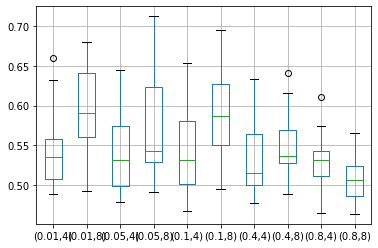

In [70]:
df = pd.DataFrame(cross_validation_accuracies.transpose(), columns=['(0.01,4)','(0.01,8)','(0.05,4)','(0.05,8)','(0.1,4)','(0.1,8)','(0.4,4)','(0.4,8)','(0.8,4)','(0.8,8)'])
df.plot.box(grid='True')

# Choosing the best set of hyperparameters

### Computing the 25th percentile value and 75 percentile value

In [82]:
cross_validation_accuracies_25p = np.percentile(cross_validation_accuracies,25,axis =1)
cross_validation_accuracies_75p = np.percentile(cross_validation_accuracies,75,axis =1)
print(cross_validation_accuracies_25p)
print(cross_validation_accuracies_75p)

[0.50806452 0.56079404 0.49844913 0.52977667 0.50217122 0.55055831
 0.50062035 0.52853598 0.51147643 0.4869727 ]
[0.55831266 0.64081886 0.57444169 0.62282878 0.58095533 0.62748139
 0.56451613 0.56916873 0.54342432 0.52388337]


### Computing the interquartile range as a measure of variability of results

In [83]:
inter_quartile_range = cross_validation_accuracies_75p - cross_validation_accuracies_25p
print(inter_quartile_range)

[0.05024814 0.08002481 0.07599256 0.09305211 0.07878412 0.07692308
 0.06389578 0.04063275 0.03194789 0.03691067]


### Computing the inverse of interquartile range as a measure of consistency of results

In [84]:
reciproc_iqr = 1/inter_quartile_range
reciproc_iqr

array([19.90123457, 12.49612403, 13.15918367, 10.74666667, 12.69291339,
       13.        , 15.65048544, 24.61068702, 31.30097087, 27.09243697])

### Computing the scores for performance of each set of hyperparameters by giving more weightage to the mean cross-validation accuracy

In [92]:
scores = reciproc_iqr + 1000*cross_validation_accuracies_mean #100 for converting to percentage and 10 as a weight
print(hyperparameters)
print(scores)

[(0.01, 4), (0.01, 8), (0.05, 4), (0.05, 8), (0.1, 4), (0.1, 8), (0.4, 4), (0.4, 8), (0.8, 4), (0.8, 8)]
[563.8218301  607.34724066 553.72990328 589.28264682 555.93112679
 600.34491315 550.57604375 571.01267213 561.69799321 534.90881415]


In [93]:
max(scores)

607.3472406563178

### From the maximum score value, we choose (0.01,8) as the best set of hyperparameters

In [126]:
chosen_hyper = (0.01,8)

# Running the Neural Network 20 times with random initialisations to compute mean Test Accuracy

In [122]:
accuracies_dash = []
for j in range(20):
    test_found_parameters = nn_model(training_set_features,training_set_outputs,chosen_hyper)
    predicted_values = predict(test_found_parameters,test_set_features)
    counter = 0
    for i in range(test_set_outputs.shape[1]):
        if test_set_outputs[0][i]==predicted_values[0][i]:
            counter+=1
    accuracy = (counter*100/test_set_outputs.shape[1])
    accuracies_dash.append(accuracy)
mean_test_accuracy_dash = sum(accuracies_dash)/len(accuracies_dash)

In [124]:
print("Mean Accuracy on Test Data = {a:2.2f} %".format(a=mean_test_accuracy_dash))
print("Maximum Accuracy on Test Data = {b:2.2f} %".format(b=max(accuracies_dash)))
print("Minimum Accuracy on Test Data = {c:2.2f} %".format(c=min(accuracies_dash)))

Mean Accuracy on Test Data = 65.71 %
Maximum Accuracy on Test Data = 75.65 %
Minimum Accuracy on Test Data = 50.14 %


# Cumulative Match Characteristic Curve

Text(0, 0.5, 'Accuracy')

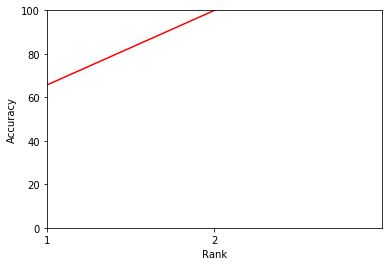

In [125]:
accuracies_values = [mean_test_accuracy_dash,100]
ranks = ['1','2']
plt.plot(ranks,accuracies_values,'r-')
plt.ylim(0,100)
plt.xlim(0,2)
plt.xlabel('Rank')
plt.ylabel('Accuracy')